In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, io
from fooof import FOOOFGroup

import warnings
warnings.filterwarnings("ignore")

sys.path.append('../')
import utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Collect fooof results and electrode info into Dataframe

In [11]:
basepath = '/Users/rdgao/Documents/data/CRCNS/fcx1/'
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/'
session_resultpath = np.sort([f for f in os.listdir(result_basepath) if os.path.isdir(result_basepath+f)])

In [58]:
meta_cols = ['rec', 'subj', 'block','cond', 'region', 'shank', 'elec']
ff_cols = ['exp', 'knee', 'tau','log_tau','err', 'r2']

def return_feature_df(win_len, p_cur, fg_param_to_load, plot_fits=False):
    df_combined = pd.DataFrame()

    if plot_fits: plt.figure(figsize=(5,5))
    for rec, s in enumerate(session_resultpath):
        # construct channel metainfo and behavioral table
        psd_data = np.load(result_basepath+s+'/psd/'+win_len+'/psds.npz')
        behav_info = psd_data['behav_info']
        ephys_data = io.loadmat(basepath+s+'/'+s+'_ephys.mat', squeeze_me=True, variable_names=['elec_shank_map', 'elec_regions'])        
        num_block, num_chan = psd_data[p_cur].shape[:2]

        # load fooof results
        fooof_folder = result_basepath + s +'/psd/'+win_len+'/fooof/'+p_cur+'/'  
        ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
        ff_file = ff_list[[fg_param_to_load in f for f in ff_list].index(True)] # load specific fooof file

        # return fooof fits and convert knee to tau
        fg_aps, fg_pks, fg_err, fg_r2s = utils.return_fg_fits(ff_file, fooof_folder)
        if fg_aps.shape[1]==3:
            knee_freq, knee_tau = utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
            knee = fg_aps[:,1]
        else:
            knee_tau = np.zeros_like(fg_aps[:,0])
            knee = np.zeros_like(fg_aps[:,0])

        # append to dataframe block-wise
        df_data = np.vstack((fg_aps[:,-1], knee, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
        df_data = df_data.astype(float)
        for b in range(num_block):
            meta_data = np.hstack([np.repeat(np.array([rec,s.split('_')[0],b,behav_info[b,0]])[None,:],num_chan, axis=0),ephys_data['elec_regions'][:,None], ephys_data['elec_shank_map']])
            df_sesh = pd.DataFrame(np.hstack((meta_data,df_data[b*num_chan:(b+1)*num_chan,:])), columns=meta_cols+ff_cols)
            df_combined=df_combined.append(df_sesh, ignore_index=True)

        # plot psds and fits
        if plot_fits:
            fit_fig_path = utils.makedir(fooof_folder, '/plts/', False)
            f_axis = psd_data['f_axis']
            psds = np.reshape(psd_data[p_cur],[-1,len(f_axis)])
            fg_labels = [f.split('.')[0][3:] for f in ff_list]
            # grab fgs
            fg_all=[]
            for ff in ff_list:
                fg_dummy = FOOOFGroup()
                fg_dummy.load(fooof_folder+ff)
                fg_all.append(fg_dummy)
            # plot
            for chan in range(num_chan*num_block):
                utils.plot_psd_fits(f_axis, psds, chan, fg_all, fg_labels)
                fig_name = win_len+'_'+'_'.join([p_cur]+df_combined.iloc[-num_chan*num_block:][meta_cols].iloc[chan].astype(str).tolist())
                plt.savefig(fit_fig_path+fig_name)
                plt.clf()

    # turn data columns into floats & drop nans
    df_combined[ff_cols]=df_combined[ff_cols].astype(float)
    return df_combined

In [59]:
plot_fits = False # change this to true to plot fits with PSDs, only need to do this once
# run these once to generate all the plots
if plot_fits:
    return_feature_df('1sec', 'psd_mean', 'knee', True).dropna()
    return_feature_df('1sec', 'psd_med', 'knee', True).dropna()
    return_feature_df('5sec', 'psd_mean', 'knee', True).dropna()
    return_feature_df('5sec', 'psd_med', 'knee', True).dropna()

In [116]:
df_combined = return_feature_df('1sec', 'psd_med', 'knee')
#df_combined = return_feature_df('1sec', 'psd_med', 'fg_fixed_2pks_30-55Hz')

# Per-channel tau-exp correlation & Wake-Sleep changes

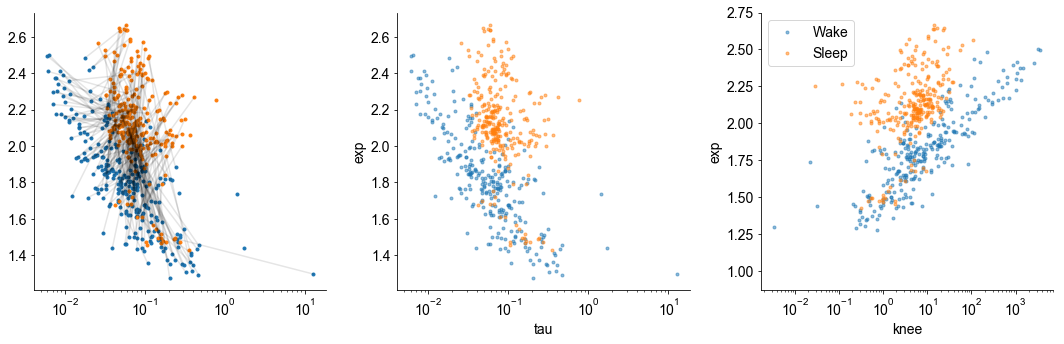

In [117]:
tau_wakesleep = np.array([df_combined[df_combined['cond']=='Wake']['tau'], df_combined[df_combined['cond']=='Sleep']['tau']])
exp_wakesleep = np.array([df_combined[df_combined['cond']=='Wake']['exp'], df_combined[df_combined['cond']=='Sleep']['exp']])
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.semilogx(tau_wakesleep[0], exp_wakesleep[0], '.', label='Wake')
plt.semilogx(tau_wakesleep[1], exp_wakesleep[1], '.', label='Sleep')
plt.semilogx(tau_wakesleep, exp_wakesleep, 'k-', alpha=0.1)
utils.remove_spines(plt.gca())

for cond in df_combined['cond'].unique()[:2]:
    df_plot = df_combined[df_combined['cond']==cond]
    plt.subplot(1,3,2)
    plt.semilogx(df_plot['tau'],df_plot['exp'],'.', alpha=0.5, label=cond)
    plt.xlabel('tau'); plt.ylabel('exp'); utils.remove_spines(plt.gca())
    # knee-exp
    plt.subplot(1,3,3)
    plt.semilogx(df_plot['knee'],df_plot['exp'],'.', alpha=0.5, label=cond)
    plt.xlabel('knee'); plt.ylabel('exp'); utils.remove_spines(plt.gca())   

plt.legend()
plt.tight_layout()

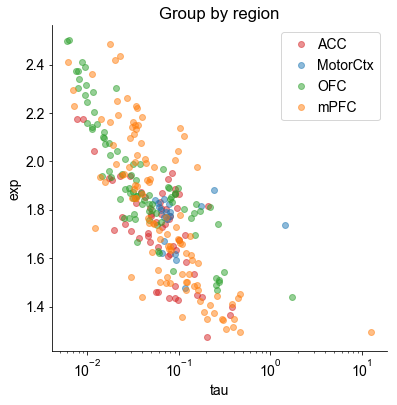

In [118]:
g_by = 'region'
regions = ['MotorCtx', 'mPFC', 'OFC', 'ACC']

plt.figure(figsize=(6,6))
for g_i, g in df_combined[df_combined['cond']=='Wake'].groupby(g_by):        
    plt.semilogx(g['tau'], g['exp'], 'o', label=g_i, alpha=0.5, color=C_ORD[regions.index(g_i)] if g_by=='region' else None)
plt.xlabel('tau'); plt.ylabel('exp'); utils.remove_spines(plt.gca()); plt.title('Group by '+g_by)
plt.legend(loc='best', handletextpad=0.2, bbox_to_anchor=[1.0,1.0])

# plot tau per region

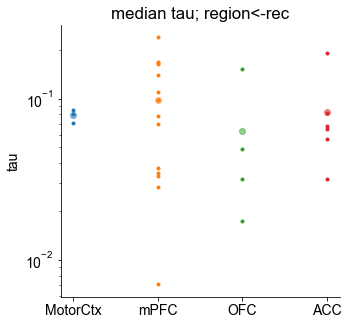

In [121]:
df_combined = df_combined.dropna()
log_y = True
mean_funcs = [np.mean, np.median, sp.stats.gmean, np.std]
mean_func = mean_funcs[1]
feature = 'tau'
agg_labels = ['region', 'rec']
agg_region = df_combined[df_combined['cond']=='Wake'].groupby(agg_labels)[ff_cols].agg(mean_func)

plt.figure(figsize=(5,5))
for g_i, g in agg_region.groupby(['region']):
    x_val = regions.index(g_i)
    plt.plot([x_val]*len(g), g[feature], '.', color=C_ORD[x_val])
    plt.plot(x_val, g.apply(mean_funcs[0])[feature], 'o', color=C_ORD[x_val],alpha=0.5)
    if log_y: plt.yscale('log')
plt.xticks(range(len(regions)), regions); plt.ylabel(feature)
plt.title(mean_func.__name__ + ' ' + feature + '; '+ '<-'.join(agg_labels))
utils.remove_spines(plt.gca())

# Visualize Spiking Data

In [79]:
def return_spiking_feature_df(win_len, p_cur, fg_param_to_load, plot_fits=False):
    meta_cols = ['rec', 'subj', 'block','cond', 'region']
    ff_cols = ['exp', 'knee', 'tau','log_tau','err', 'r2']
    cell_cols =['cell_EI_type','cell_id','num_spikes','shank','lfp_chan_ind']

    if plot_fits: plt.figure(figsize=(5,5))
    df_combined = pd.DataFrame()
    
    for rec, s in enumerate(session_resultpath):
        # construct channel metainfo and behavioral table
        psd_spikes_data = np.load(result_basepath+s+'/psd_spikes/'+win_len+'/psds.npz')
        behav_info = psd_spikes_data['behav_info']
        ephys_data = io.loadmat(basepath+s+'/'+s+'_ephys.mat', squeeze_me=True, variable_names=['elec_shank_map', 'elec_regions'])
        df_spkinfo_pop = pd.read_csv(result_basepath+s+'/psd_spikes/pop_spike_info.csv', index_col=0)
        num_block = psd_spikes_data[p_cur].shape[0]
        num_cell = len(df_spkinfo_pop)

        # load fooof results
        fooof_folder = result_basepath + s +'/psd_spikes/'+win_len+'/fooof/'+p_cur+'/'  
        ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
        ff_file = ff_list[[fg_param_to_load in f for f in ff_list].index(True)] # load specific fooof file

        # return fooof fits and convert knee to tau
        fg_aps, fg_pks, fg_err, fg_r2s = utils.return_fg_fits(ff_file, fooof_folder)
        if fg_aps.shape[1]==3:
            knee_freq, knee_tau = utils.convert_knee_val(fg_aps[:,1],fg_aps[:,2])
            knee = fg_aps[:,1]
        else:
            knee_tau = np.zeros_like(fg_aps[:,0])
            knee = np.zeros_like(fg_aps[:,0])

        # append to dataframe block-wise
        df_data = np.vstack((fg_aps[:,-1], knee, knee_tau, np.log10(knee_tau), fg_err, fg_r2s)).T
        df_data = pd.DataFrame(df_data.astype(float), columns=ff_cols)
                
        # append lfp channel number and various other meta data for easier access later
        lfp_chan_ind = np.nan*np.ones(num_cell)
        for i, shank in enumerate(df_spkinfo_pop['shank'].values):
            lfp_chan = np.where(ephys_data['elec_shank_map'][:,0]==shank)[0]
            if len(lfp_chan): lfp_chan_ind[i]=lfp_chan[0]
        df_spkinfo_pop.insert(len(df_spkinfo_pop.columns), 'lfp_chan_ind', lfp_chan_ind)

        df_rec = pd.DataFrame()
        for b in range(num_block):
            meta_data = np.hstack([np.repeat(np.array([rec,s.split('_')[0],b,behav_info[b,1], ephys_data['elec_regions'][0]])[None,:],num_cell, axis=0)])
            df_meta = pd.concat([pd.DataFrame(meta_data, columns=meta_cols[:5]), df_spkinfo_pop[cell_cols].reset_index(drop=True)], axis=1, join='outer')
            df_rec = df_rec.append(df_meta, ignore_index=True)

        df_rec = pd.concat([df_rec, df_data.reset_index(drop=True)], axis=1)
        df_combined = df_combined.append(df_rec, ignore_index=True)

        # plot psds and fits
        if plot_fits:
            fit_fig_path = utils.makedir(fooof_folder, '/plts/', False)
            f_axis = psd_spikes_data['f_axis']
            psds = np.reshape(psd_spikes_data[p_cur][:, -num_cell:,:],[-1,len(f_axis)])
            fg_labels = [f.split('.')[0][3:] for f in ff_list]
            # grab fgs
            fg_all=[]
            for ff in ff_list:
                fg_dummy = FOOOFGroup()
                fg_dummy.load(fooof_folder+ff)
                fg_all.append(fg_dummy)
            # plot
            for chan in range(num_cell*num_block):
                utils.plot_psd_fits(f_axis[f_axis<=80.], psds[:, f_axis<=80.], chan, fg_all, fg_labels)
                fig_name = win_len+'_'+'_'.join([p_cur]+df_rec[meta_cols+[cell_cols[0],cell_cols[3]]].iloc[chan].astype(str).tolist())
                plt.savefig(fit_fig_path+fig_name)
                plt.clf()

    return df_combined

In [22]:
return_spiking_feature_df('/2sec', 'psd_mean', 'fg_fixed_1pks_0-5Hz', True)
return_spiking_feature_df('/5sec', 'psd_mean', 'fg_fixed_1pks_0-5Hz', True)

20140526_277um
20140527_421um
20140528_565um
BWRat17_121712
BWRat17_121912
BWRat18_020513
BWRat19_032413
BWRat19_032513
BWRat20_101013
BWRat20_101513
BWRat21_121113
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/BWRat21_121113/psd_spikes//2sec/fooof/psd_mean//plts/
BWRat21_121613
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/BWRat21_121613/psd_spikes//2sec/fooof/psd_mean//plts/
BWRat21_121813
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/BWRat21_121813/psd_spikes//2sec/fooof/psd_mean//plts/
Bogey_012615
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/Bogey_012615/psd_spikes//2sec/fooof/psd_mean//plts/
Dino_061814_mPFC
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/Dino_061814_mPFC/psd_spikes//2sec/fooof/psd_mean//plts/
Dino_061914_ACC
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/Dino_061914_ACC/psd_spikes//2sec/fooof/psd_mean//plts/
Di

,rec,subj,block,cond,region,cell_EI_type,cell_id,num_spikes,shank,lfp_chan_ind,exp,knee,tau,log_tau,err,r2
0,26,Templeton,0,Wake,mPFC,1,0,24029,1,0.0,0.330386,0.0,0.0,-inf,0.022871,0.897704
1,26,Templeton,0,Wake,mPFC,1,0,44848,2,1.0,0.159635,0.0,0.0,-inf,0.013898,0.817704
2,26,Templeton,0,Wake,mPFC,1,0,55313,4,2.0,0.301173,0.0,0.0,-inf,0.011281,0.969528
3,26,Templeton,0,Wake,mPFC,1,0,124190,0,NaN,0.268010,0.0,0.0,-inf,0.014823,0.941385
4,26,Templeton,1,Wake,mPFC,1,0,24029,1,0.0,0.360364,0.0,0.0,-inf,0.024770,0.909890
5,26,Templeton,1,Wake,mPFC,1,0,44848,2,1.0,0.259182,0.0,0.0,-inf,0.015253,0.921429
6,26,Templeton,1,Wake,mPFC,1,0,55313,4,2.0,0.222326,0.0,0.0,-inf,0.023135,0.771475
7,26,Templeton,1,Wake,mPFC,1,0,124190,0,NaN,0.283756,0.0,0.0,-inf,0.022490,0.872574
8,26,Templeton,2,Wake,mPFC,1,0,24029,1,0.0,0.259368,0.0,0.0,-inf,0.040417,0.667660
9,26,Templeton,2,Wake,mPFC,1,0,44848,2,1.0,0.383242,0.0,0.0,-inf,0.018665,0.929178


In [114]:
print('LFP FOOOFs')
fooof_folder = result_basepath + '20140526_277um' +'/psd/5sec/fooof/psd_med/'
ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
ff_list

LFP FOOOFs


['fg_fixed_2pks_30-55Hz.json',
 'fg_fixed_4pks_0-200Hz.json',
 'fg_knee_4pks_0-200Hz.json',
 'fg_fixed_2pks_0-10Hz.json']

In [112]:
print('Spike FOOOFs')
fooof_folder = result_basepath + '20140526_277um' +'/psd_spikes/5sec/fooof/psd_mean/'
ff_list = [ff for ff in os.listdir(fooof_folder) if '.json' in ff]
ff_list

Spike FOOOFs


['fg_fixed_1pks_0-5Hz.json',
 'fg_fixed_1pks_30-80Hz.json',
 'fg_fixed_1pks_10-20Hz.json',
 'fg_fixed_2pks_0-80Hz.json']

In [101]:
df_combined = return_feature_df('/5sec', 'psd_med', 'fg_fixed_2pks_30-55Hz')
df_combined_spiking = return_spiking_feature_df('/5sec', 'psd_mean', 'fg_fixed_1pks_0-5Hz', False)

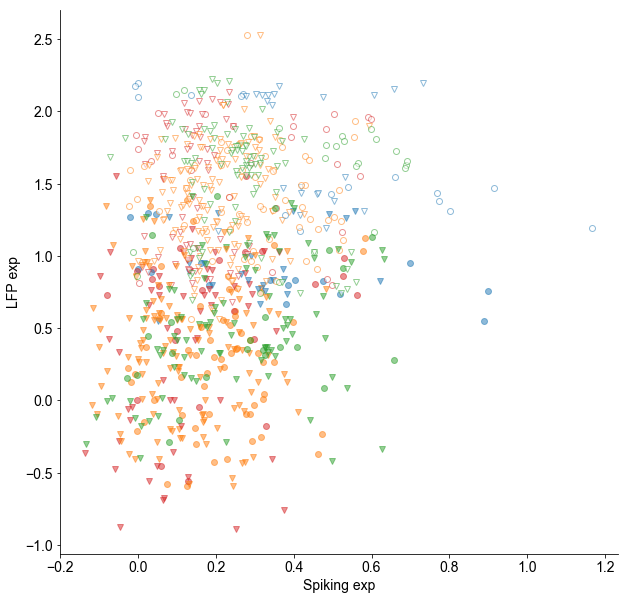

In [104]:
spike_feat = 'exp'
lfp_feat = 'exp'
df_subset = df_combined_spiking

plt.figure(figsize=(10,10))
for cell, cell_data in df_subset.iterrows():
    match_cols = ['rec', 'block', 'shank']
    lfp_loc = df_combined[(df_combined[match_cols]==cell_data[match_cols]).all(axis=1)]
    if len(lfp_loc):
        #plt.plot(cell_data[spike_feat], lfp_loc[lfp_feat], '.k', alpha=0.5)
        plt.plot(cell_data[spike_feat], lfp_loc[lfp_feat], 
                 color=C_ORD[regions.index(cell_data['region'])],
                 marker='v' if cell_data['cell_EI_type']==1 else 'o',
                 mfc='w' if cell_data['cond']=='Sleep' else None,
                 alpha=0.5)
        
#plt.yscale('log')
plt.xlabel('Spiking %s'%spike_feat)
plt.ylabel('LFP %s'%lfp_feat)
utils.remove_spines(plt.gca())